Reduce variance and increases bias.

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



'data.frame':	97 obs. of  10 variables:
 $ lcavol : num  -0.58 -0.994 -0.511 -1.204 0.751 ...
 $ lweight: num  2.77 3.32 2.69 3.28 3.43 ...
 $ age    : int  50 58 74 58 62 50 64 58 47 63 ...
 $ lbph   : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ svi    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ lcp    : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ gleason: int  6 6 7 6 6 6 6 6 6 6 ...
 $ pgg45  : int  0 0 20 0 0 0 0 0 0 0 ...
 $ lpsa   : num  -0.431 -0.163 -0.163 -0.163 0.372 ...
 $ train  : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.0000000,0.2805214,0.2249999,0.027349703,0.53884500,0.675310484,0.43241706,0.43365225
lweight,0.2805214,1.0000000,0.3479691,0.442264395,0.15538491,0.164537146,0.05688210,0.10735379
age,0.2249999,0.3479691,1.0000000,0.350185896,0.11765804,0.127667752,0.26889160,0.27611245
lbph,0.0273497,0.4422644,0.3501859,1.000000000,-0.08584324,-0.006999431,0.07782045,0.07846002
svi,0.5388450,0.1553849,0.1176580,-0.085843238,1.00000000,0.673111185,0.32041222,0.45764762
lcp,0.6753105,0.1645371,0.1276678,-0.006999431,0.67311118,1.000000000,0.51483006,0.63152825
gleason,0.4324171,0.0568821,0.2688916,0.077820447,0.32041222,0.514830063,1.00000000,0.75190451
pgg45,0.4336522,0.1073538,0.2761124,0.078460018,0.45764762,0.631528246,0.75190451,1.00000000


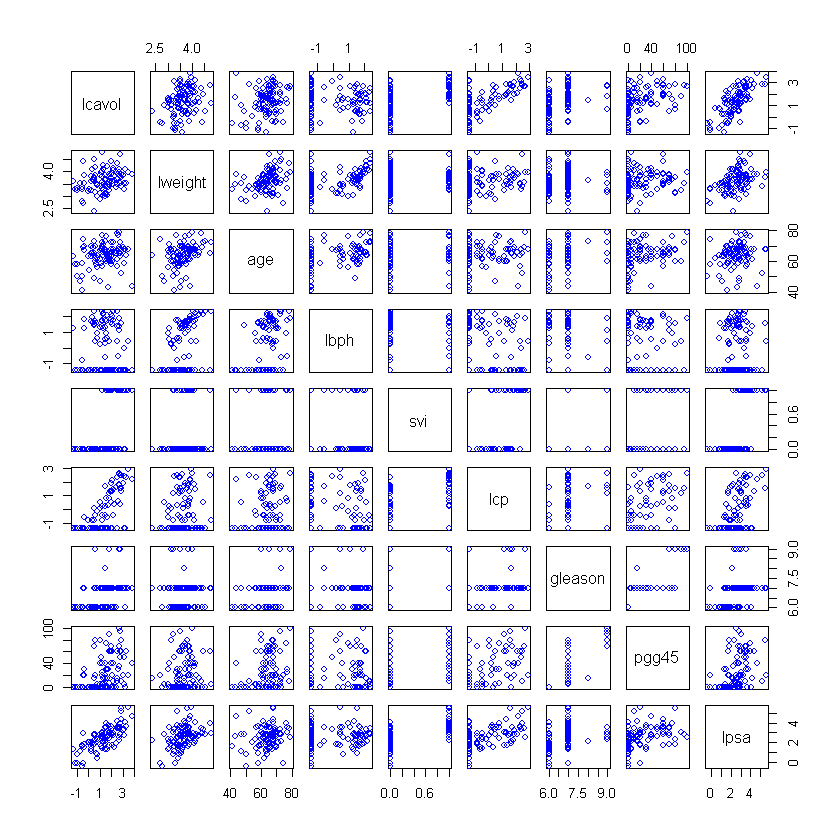

In [1]:
library(glmnet)
library(ElemStatLearn)
data(prostate)
str(prostate)
cor(prostate[,1:8])
pairs(prostate[,1:9], col="blue")

In [8]:
train <- subset (prostate, train == TRUE) [,1:9]
test <- subset (prostate, train == FALSE) [,1:9]

We use elastic net -- alpha determines how much of lambda is allocated to the square and absolute penalties. The function starts with lambda large enough to force $\beta_\lambda$ to be zero and then shrinks it to the lambda.min.ratio value logarithmically.

          Length Class     Mode   
a0         795   -none-    numeric
beta      6360   dgCMatrix S4     
df         795   -none-    numeric
dim          2   -none-    numeric
lambda     795   -none-    numeric
dev.ratio  795   -none-    numeric
nulldev      1   -none-    numeric
npasses      1   -none-    numeric
jerr         1   -none-    numeric
offset       1   -none-    logical
call         6   -none-    call   
nobs         1   -none-    numeric

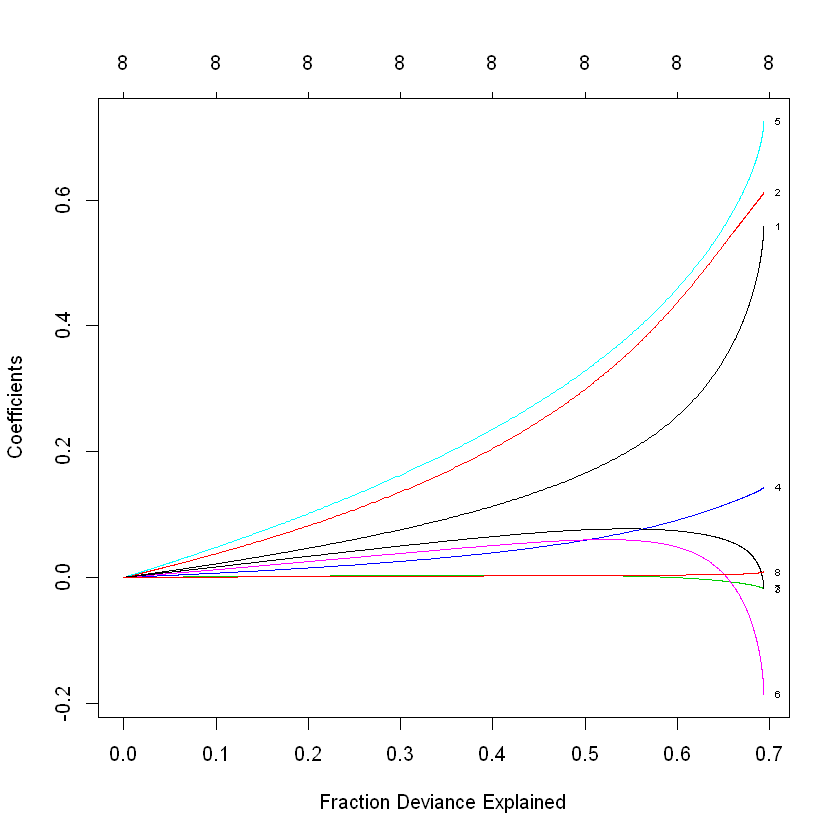

In [7]:
X <- data.matrix(train[,1:8])
Y <- train$lpsa

prostate.ridge <- glmnet(X,Y,alpha=0, lambda.min.ratio=1e-6,nlambda=1000)

summary(prostate.ridge)

plot(prostate.ridge,xvar = "dev", label=TRUE)

Naturally, as the complexity of the model increases, it explains more of the deviance. Observe what happens if we plot with respect to $\lambda$ instead:

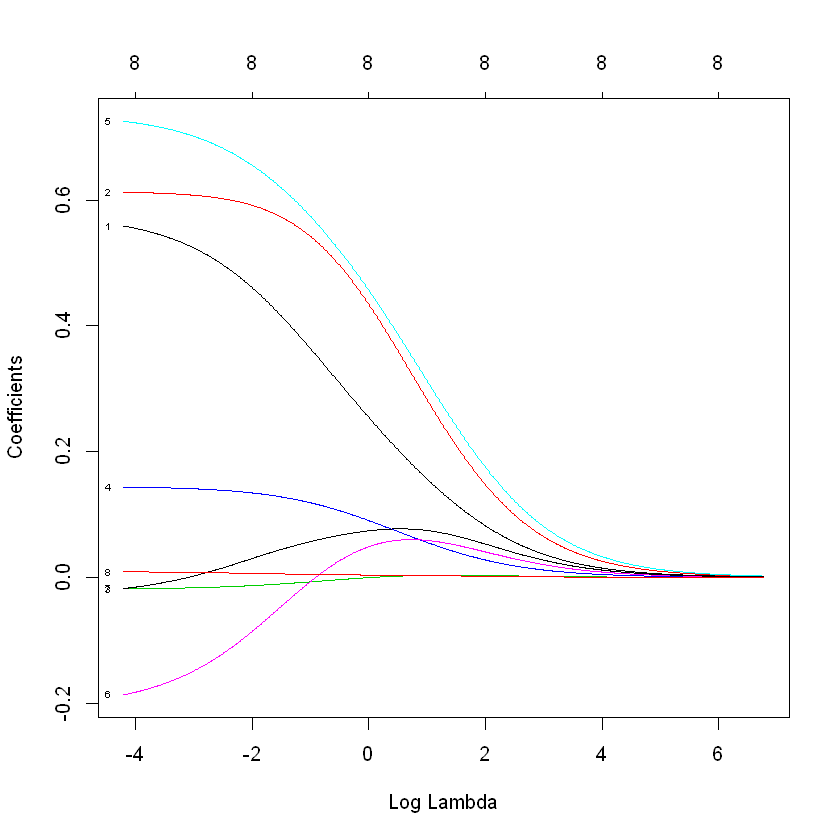

In [10]:
plot(prostate.ridge,xvar = "lambda", label=TRUE)

As lambda increases, we shrink the coeffecients down. Note that it doensn't quite squash it to 0. We can choose the optimal $\lambda$ using CV.

[1] 0.04985211

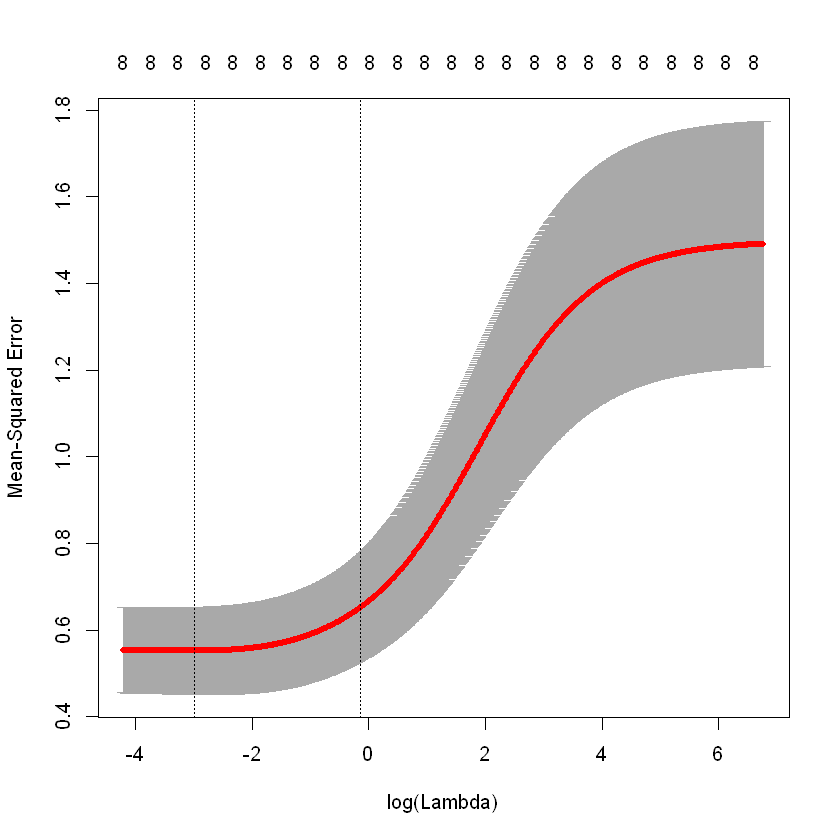

In [11]:
set.seed(2018)
prostate.cvridge <-cv.glmnet(X,Y, alpha=0, lambda = prostate.ridge$lambda ,nfolds=10)
prostate.cvridge$lambda.min
plot(prostate.cvridge)

This is minimised at the first dotted line. The other line indicates the confidence interval for the minimum.

s707 
0.205

lcavol lweight     age    lbph     svi     lcp gleason   pgg45 
  0.524   0.608  -0.016   0.141   0.701  -0.149   0.002   0.008

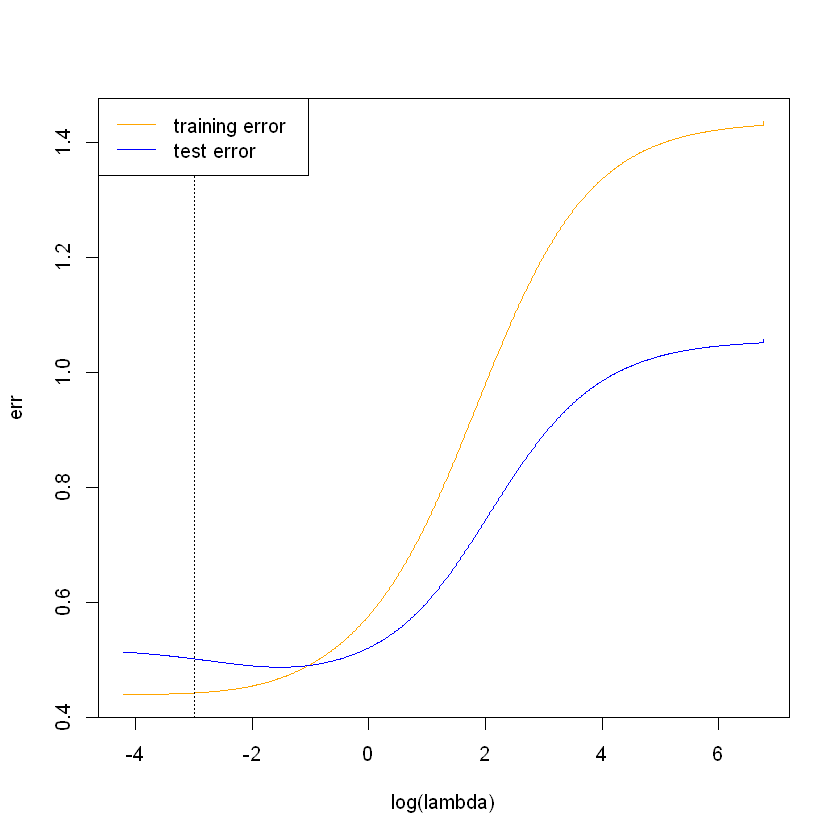

In [15]:
ind <- prostate.ridge$lambda == prostate.cvridge$lambda.min
round(prostate.ridge$a0[ind],3)

round(prostate.ridge$beta[,ind],3)

Yhat <- predict(prostate.ridge, X)
train_err <- colMeans((Y - Yhat)^2)
X_new <- data.matrix(test[,1:8])
Y_new <- test$lpsa
Y_newhat <- predict(prostate.ridge, X_new)
test_err <- colMeans((Y_new - Y_newhat)^2)
plot(log(prostate.ridge$lambda), train_err, col='orange', type='l',
ylab='err', xlab='log(lambda)')
points(log(prostate.ridge$lambda), test_err, col='blue', type='l')
abline(v=log(prostate.cvridge$lambda.min),lty=3)
legend('topleft', c("training error","test error"),
lty=1, col=c('orange','blue'))

We compare the performance between the test error and training error of the method. Naturally, the training error increases as we decrease the complexity of the model by inreasing $\lambda$. The test error initially decreases as the regularisation reduces overfitting, before increasing. Our cross validation has not chosen a terrible set of parameters, despite not minimising the test error, especially consider the flat tail of the curve. (Note that this is a population test error)


Now let use try a LASSO.

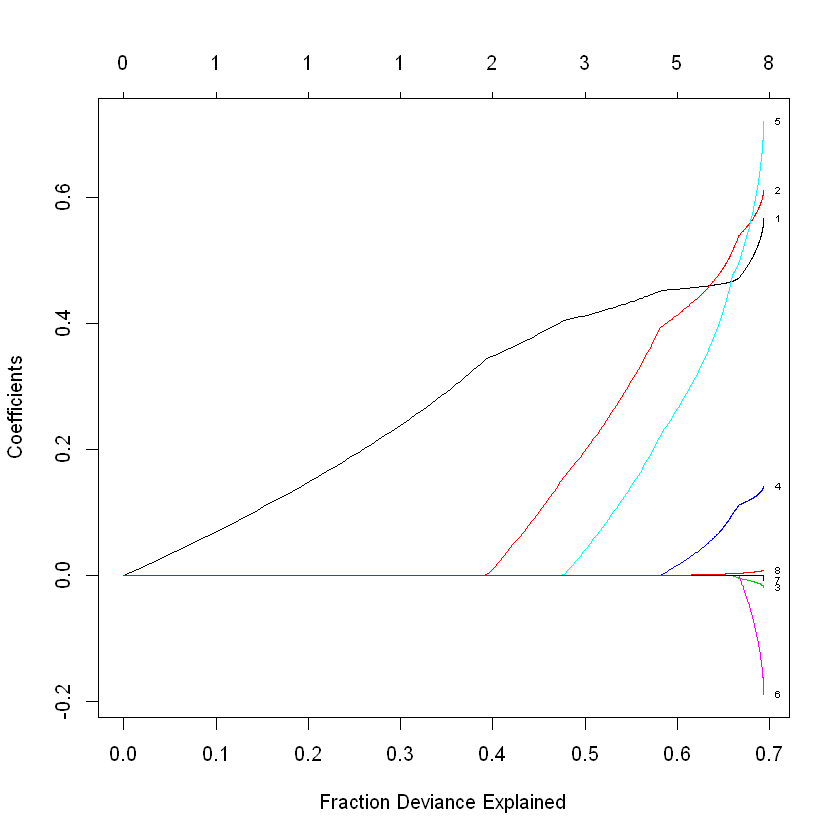

In [17]:
prostate.lasso <- glmnet(X,Y,alpha=1,lambda.min.ratio=1e-6,nlambda=1000)
plot(prostate.lasso, xvar = 'dev', label=TRUE)

Note that some of the coeffecients are at 0. This is more frequent at low complexity.

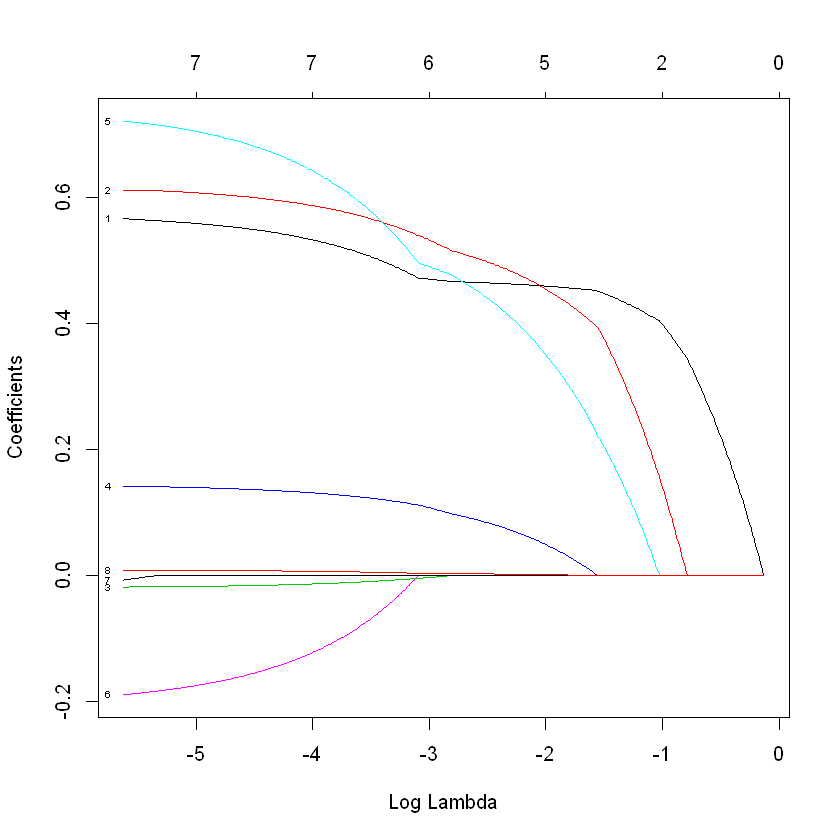

In [21]:
plot(prostate.lasso, xvar = 'lambda', label=TRUE)

Again, we have a look at the coeffecients plotted against lambda. Also, we try to select a model with cross validation.

Note that here, the fleason coeffecient has been set to 0.

[1] 0.01312514

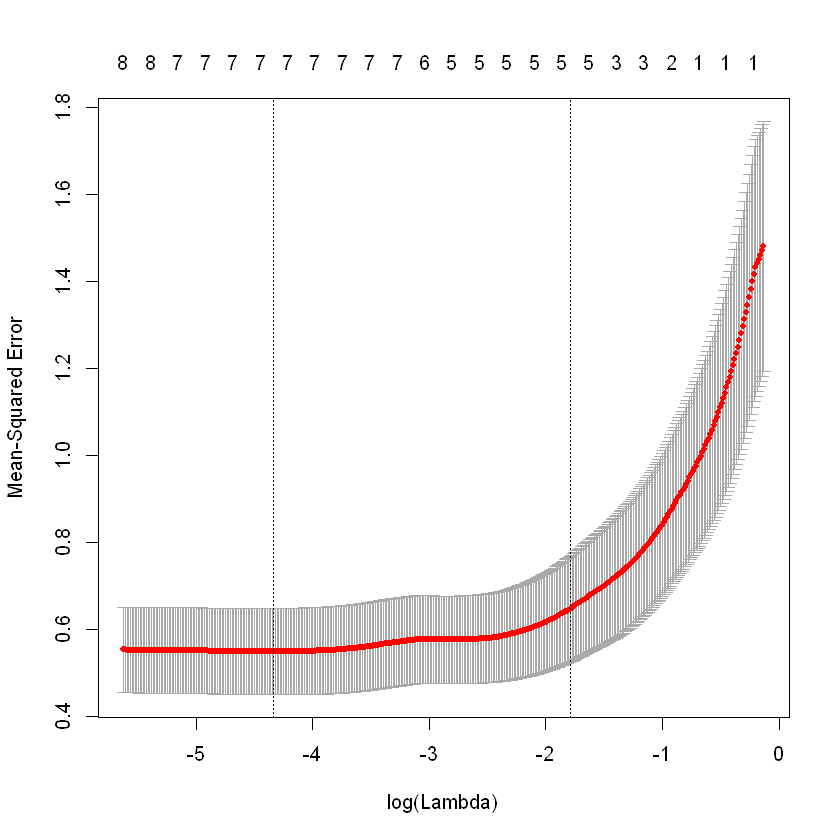

In [27]:
set.seed(2018)
prostate.cvlasso <- cv.glmnet(X,Y,alpha=1,lambda=prostate.lasso$lambda,nfolds=10)
prostate.cvlasso$lambda.min # optimal regularisation parameter
ind <- prostate.lasso$lambda==prostate.cvlasso$lambda.min
plot(prostate.cvlasso

s304 
0.166

lcavol lweight     age    lbph     svi     lcp gleason   pgg45 
  0.544   0.596  -0.015   0.135   0.670  -0.146   0.000   0.007

s304 
0.166

lcavol lweight     age    lbph     svi     lcp gleason   pgg45 
  0.544   0.596  -0.015   0.135   0.670  -0.146   0.000   0.007

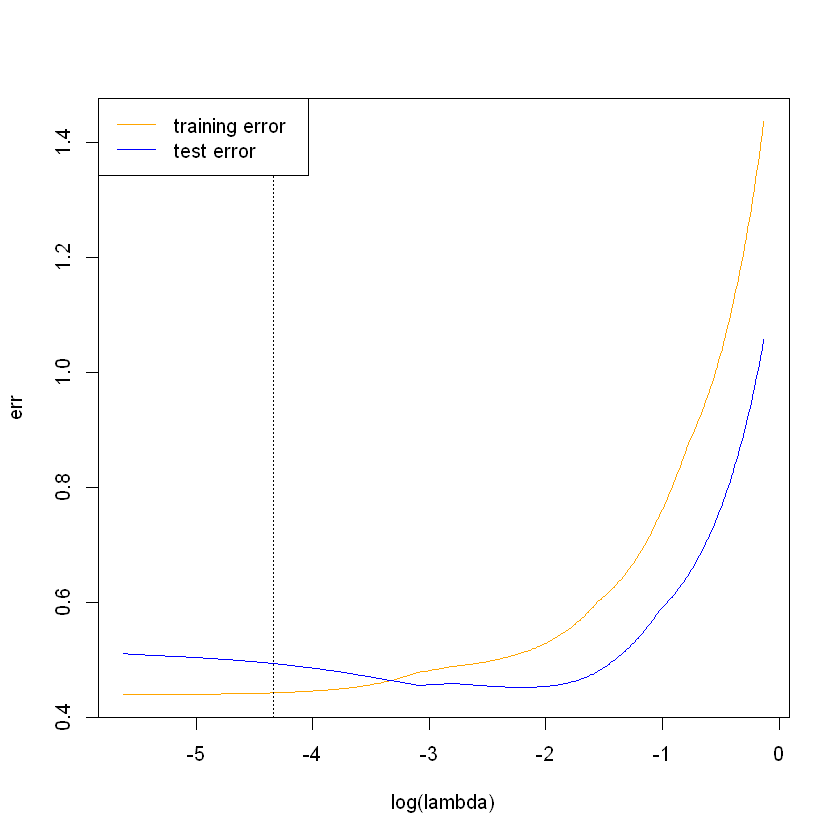

In [29]:
round(prostate.lasso$a0[ind], 3) # intercept
## 0.166
round(prostate.lasso$beta[,ind], 3) # coefficients

ind <- prostate.lasso$lambda == prostate.cvlasso$lambda.min
round(prostate.lasso$a0[ind],3)

round(prostate.lasso$beta[,ind],3)

Yhat <- predict(prostate.lasso, X)
train_err <- colMeans((Y - Yhat)^2)
X_new <- data.matrix(test[,1:8])
Y_new <- test$lpsa
Y_newhat <- predict(prostate.lasso, X_new)
test_err <- colMeans((Y_new - Y_newhat)^2)
plot(log(prostate.lasso$lambda), train_err, col='orange', type='l',
ylab='err', xlab='log(lambda)')
points(log(prostate.lasso$lambda), test_err, col='blue', type='l')
abline(v=log(prostate.cvlasso$lambda.min),lty=3)
legend('topleft', c("training error","test error"),
lty=1, col=c('orange','blue'))


Now let's have a look at the GWAS dataset.

In [31]:
filePath <- "http://www.statslab.cam.ac.uk/~tw389/teaching/SLP18/data/"
fileName <- "gwas"
gwas <- read.table(paste0(filePath, fileName), header=TRUE) # this may take a while
dim(gwas); n <- dim(gwas)[1]; p <- dim(gwas)[2]-2
gwas[1:10,1:10]

[1]    89 66538

pid,disease,rs6681049_1,rs4074137_1,rs1891905_1,rs9729550_1,rs3813196_1,rs12044597_1,rs10907185_1,rs11260616_1
HCB181,1,0,0,1,0,0,1,0,0
HCB182,1,0,1,1,1,0,0,1,1
HCB183,0,0,1,1,1,0,1,1,1
HCB184,1,0,1,1,0,0,1,0,0
HCB185,1,0,1,0,0,0,1,0,0
HCB186,1,0,0,1,0,0,0,1,1
HCB187,1,0,0,1,1,0,1,1,1
HCB188,1,0,1,1,0,0,1,1,0
HCB189,0,0,0,0,0,0,1,0,0
HCB190,0,0,0,0,0,0,1,1,1



Attaching package: 'rje'

The following object is masked from 'package:base':

    arrayInd



0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%85%86%87%88%89%90%91%92%93%94%95%96%97%98%99%100%


[1] "rs1015896_2"  "rs1119114_1"  "rs10830072_1" "rs7182018_1"  "rs1230896_1" 
[6] "rs9482200_2"

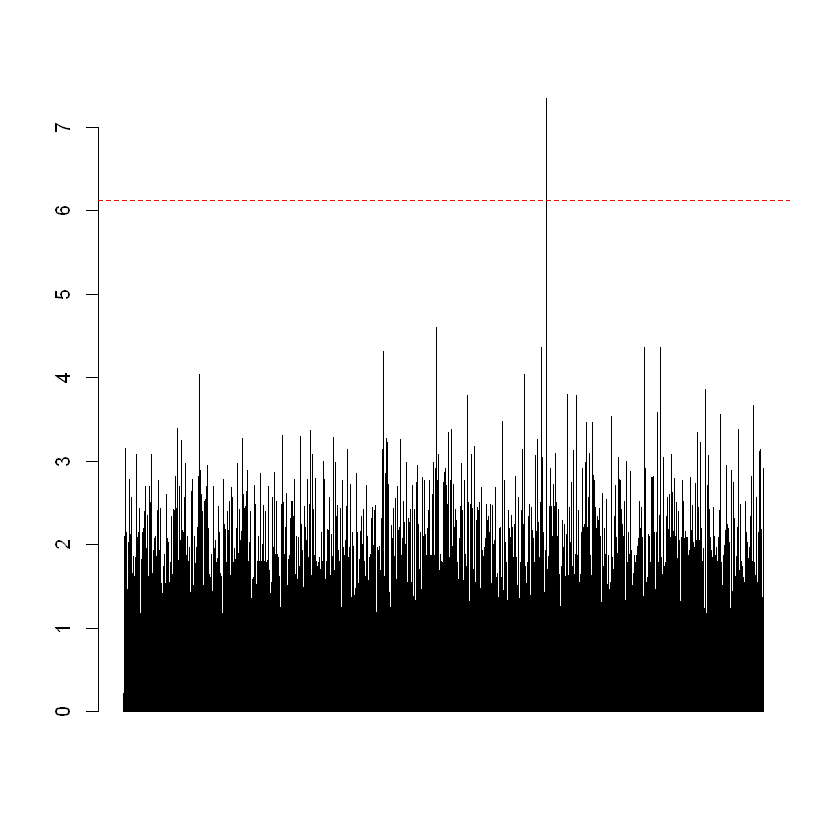

In [36]:
library(rje)
dev <- rep(0,p)
for (j in 1:p){
dev[j] <- glm(disease~.,family='binomial',data=gwas[,c(2,2+j)])$deviance
printPercentage(j,p)
}
nulldeviance <- glm(disease~1, family='binomial', data=gwas)$null.deviance
pval <- 1 - pchisq(nulldeviance - dev, 1)
barplot(-log10(pval)) # Manhattan plot
abline(h=-log10(0.05/p), col='red',lty=2) # p-val = 0.05/p
colnames(gwas)[order(pval)[1:6]+2] # 6 most significant SNPs

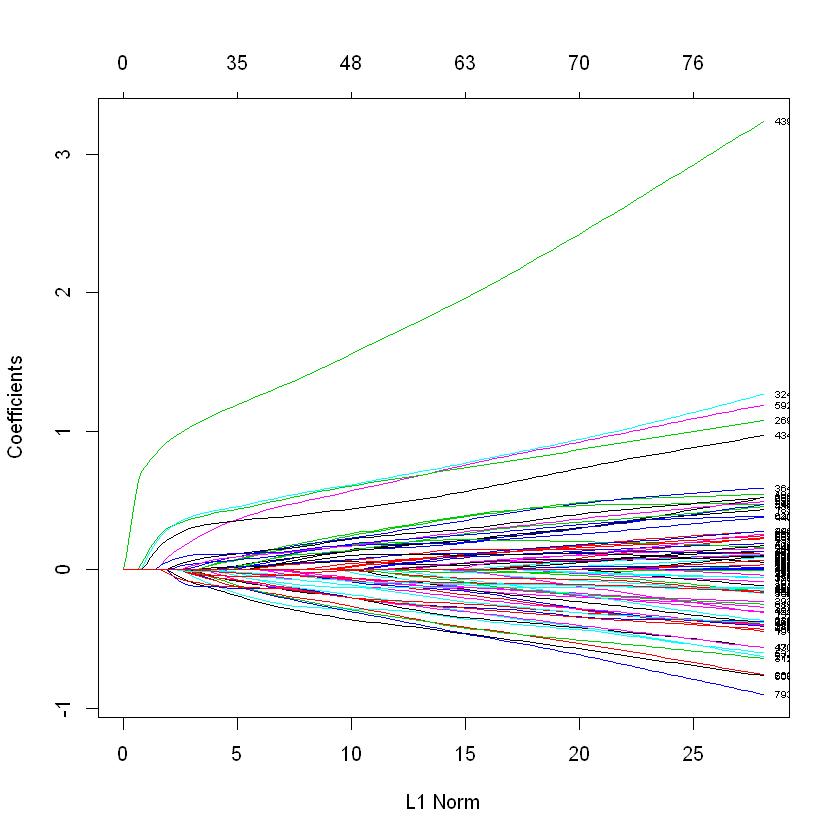

In [37]:
X <- data.matrix(gwas[,-c(1,2)])
Y <- gwas$disease
gwas.lasso <- glmnet(X,Y,alpha=1,family='binomial')
plot(gwas.lasso, label=TRUE)

[1] 0.1761613

s10 
-0.408

rs9482200_2  rs1119114_1 rs10830072_1  rs1015896_2 
       0.159        0.133        0.087        0.796

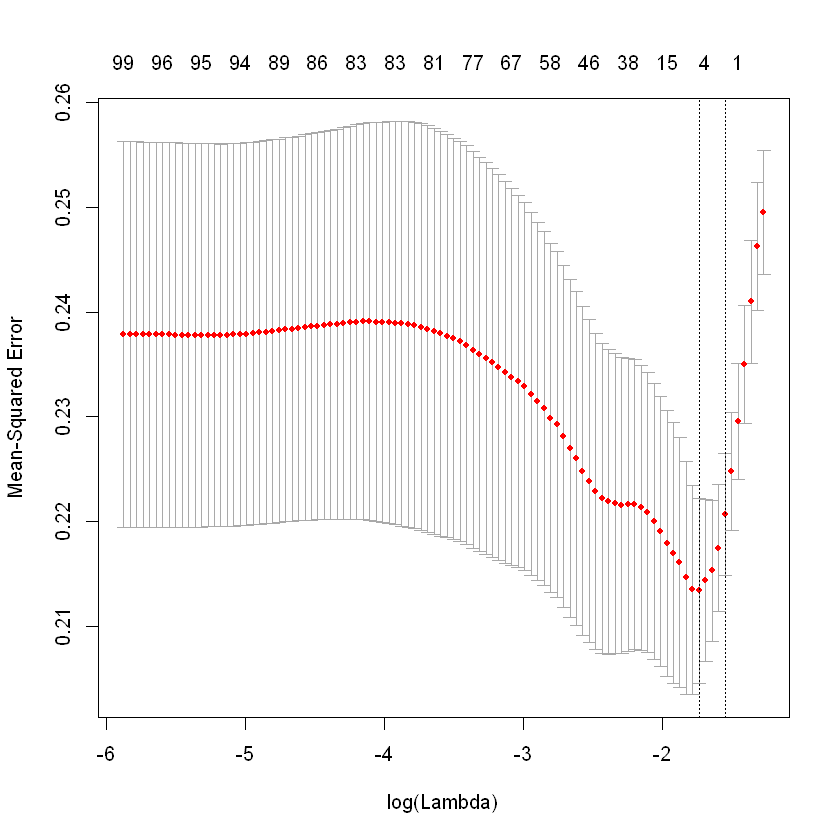

In [38]:
set.seed(2018)
gwas.cvlasso <- cv.glmnet(X,Y,alpha=1,lambda=gwas.lasso$lambda,nfolds=10)
plot(gwas.cvlasso)
gwas.cvlasso$lambda.min
ind <- gwas.lasso$lambda==gwas.cvlasso$lambda.min
round(gwas.lasso$a0[ind], 3)
betahat <- round(gwas.lasso$beta[,ind], 3)
betahat[betahat!=0]


As we can see, all but 4 coefficients have been set to 0. Try again using GWAS_Small -- notice that now 19 have been chosen, include the same 4 as before. 

Lasso will choose more agressive regularisation for larger dimensional data, since we want to reduce the variance more in these high dimensional models.

[1]   89 4000

pid,disease,rs2236287_1,rs3778172_1,rs2610728_1,rs2026020_1,rs9294415_1,rs9359816_1,rs1321086_1,rs9359827_1
HCB181,1,0,0,0,0,0,0,0,0
HCB182,1,0,0,0,0,0,0,0,0
HCB183,0,0,0,0,0,0,0,0,0
HCB184,1,1,0,1,1,1,1,1,1
HCB185,1,1,0,1,1,1,1,1,1
HCB186,1,0,0,0,0,0,0,0,0
HCB187,1,0,0,0,0,0,0,0,0
HCB188,1,0,0,0,0,0,0,0,0
HCB189,0,0,0,0,0,0,0,0,0
HCB190,0,1,1,1,1,1,1,1,1


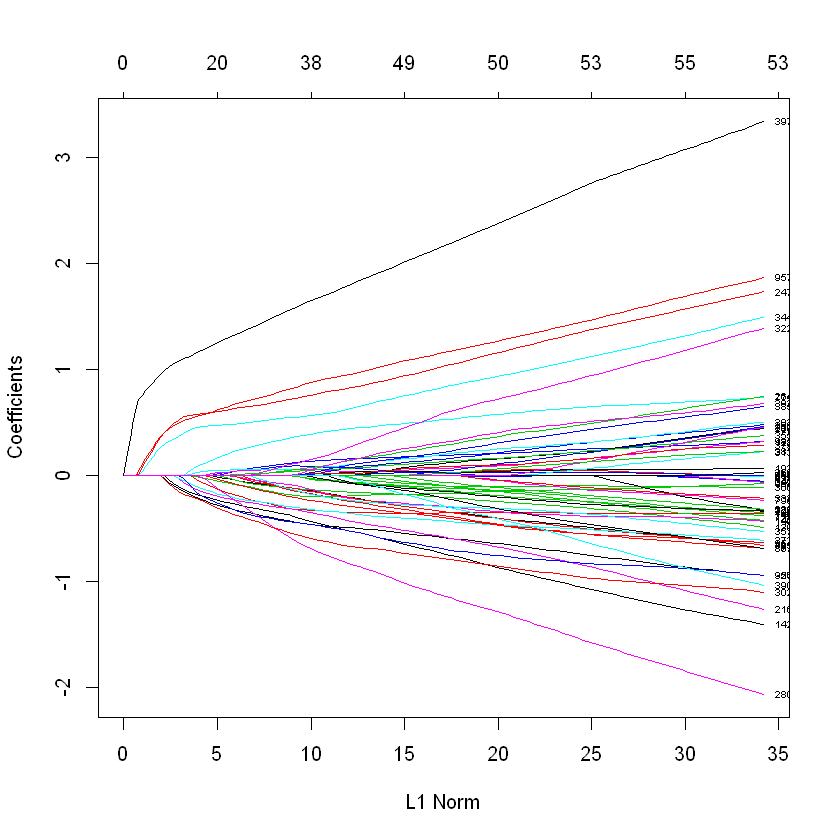

[1] 0.09622421

s23 
-0.828

rs9362780_1  rs6915372_1 rs12203915_1  rs9482200_2   rs699398_1 rs13204337_1 
      -0.005        0.144       -0.263        0.597       -0.043        0.003 
 rs4895943_2  rs2504376_1  rs6927460_1  rs2341797_1 rs10088720_1  rs1119114_1 
       0.014       -0.219       -0.106        0.044       -0.178        0.595 
 rs6474087_1   rs998791_1  rs7923559_1 rs10830072_1  rs2164287_1  rs7077560_1 
      -0.155       -0.081       -0.281        0.469       -0.017       -0.240 
 rs1015896_2 
       1.222

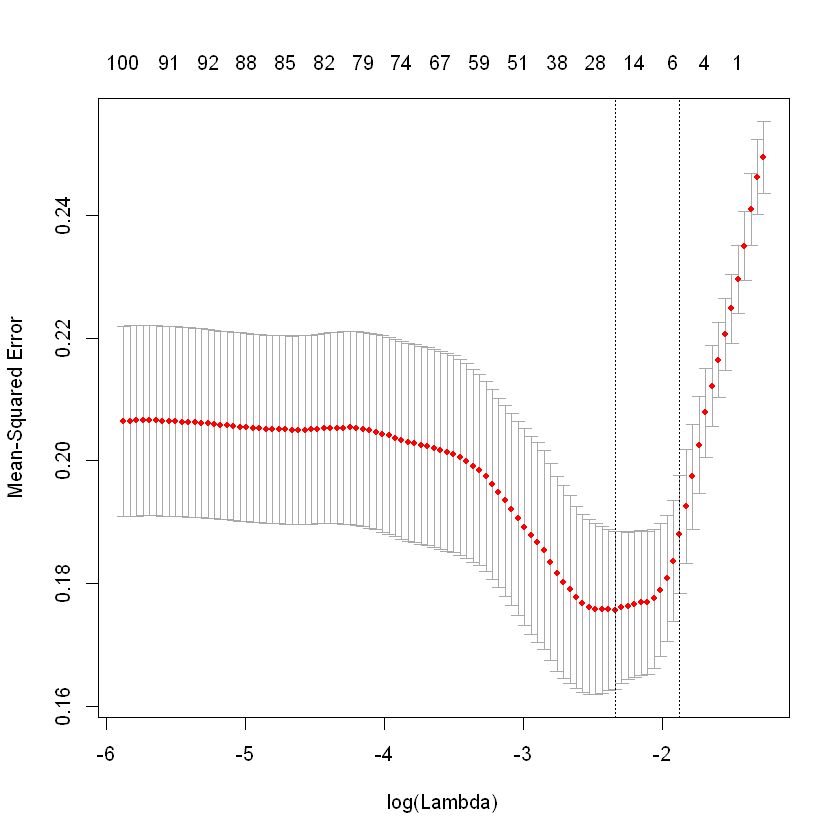

In [40]:
filePath <- "http://www.statslab.cam.ac.uk/~tw389/teaching/SLP18/data/"
fileName <- "gwas_small"
gwas_small <- read.table(paste0(filePath, fileName), header=TRUE) # this may take a while
dim(gwas_small); n <- dim(gwas)[1]; p <- dim(gwas_small)[2]-2
gwas_small[1:10,1:10]

X <- data.matrix(gwas_small[,-c(1,2)])
Y <- gwas_small$disease
gwas_small.lasso <- glmnet(X,Y,alpha=1,family='binomial')
plot(gwas_small.lasso, label=TRUE)

set.seed(2018)
gwas_small.cvlasso <- cv.glmnet(X,Y,alpha=1,lambda=gwas_small.lasso$lambda,nfolds=10)
plot(gwas_small.cvlasso)
gwas_small.cvlasso$lambda.min
ind <- gwas_small.lasso$lambda==gwas_small.cvlasso$lambda.min
round(gwas_small.lasso$a0[ind], 3)
betahat <- round(gwas_small.lasso$beta[,ind], 3)
betahat[betahat!=0]
